# First Exploratory Notebook

Steps:

1. Data Exploration
2. Duplicates
3. Missing Data
4. Outliers
5. Scaling
6. Balancing
7. Feature Engineering (Encoding, Discretizing, Create New Features)
8. Feature correlation and selection
9. Modelling
10. Further Feature Selection
11. Remodelling

## Data Preparation

In [124]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

##Script specific imports for feature encoding

from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import set_config
set_config(display='diagram')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_validate
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

from sklearn import set_config; set_config(display='diagram')
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import TransformerMixin, BaseEstimator

In [2]:
file = r'/home/mnm7/code/sandbox/WSC - variable cross-check_v1.csv'
data = r'/home/mnm7/code/sandbox/wsc-dataset-0.2.0.csv'

In [3]:
df = pd.read_csv(file)
data_df = pd.read_csv(data)

In [4]:
data_df['nasal_cong_none'].fillna(0, inplace=True)

In [5]:
deleted = df[df['Proposed Removal'] == 'R']
deleted_cols = deleted.iloc[:, 0]

In [6]:
data_df = data_df.drop(deleted_cols.to_list(), axis=1)

In [7]:
data_df.isnull().sum().sort_values(ascending=False)/len(data_df)

psg_oxygen         0.997665
psg_cpap           0.935019
cigars_day         0.919844
bowls_day          0.917899
thyroid_problem    0.867704
                     ...   
nasal_cong_none    0.000000
awake_freq         0.000000
apnea_freq         0.000000
choke_freq         0.000000
waso               0.000000
Length: 134, dtype: float64

In [8]:
balance_cutoff = 0.9
imbalanced_classes = []
for col in data_df.columns:
    _ = data_df.columns.get_loc(col)
    if data_df.iloc[:, _].value_counts(normalize=True).head(1).values > balance_cutoff:
        imbalanced_classes.append((col, data_df.iloc[:, _].value_counts(normalize=True).head(1).values.astype(float)))

### Imbalanced Classes

In [9]:
imbalanced_classes

[('race', array([0.95836576])),
 ('coronary_ynd', array([0.9233463])),
 ('angina_ynd', array([0.96730245])),
 ('atheroscl_ynd', array([0.9758661])),
 ('heartattack_ynd', array([0.95679253])),
 ('congestivehf_ynd', array([0.98871595])),
 ('coronarybypass_ynd', array([0.95525292])),
 ('stroke_ynd', array([0.97743191])),
 ('emphysema_ynd', array([0.97898833])),
 ('angioplasty_ynd', array([0.95758755])),
 ('pacemaker_ynd', array([0.99105058])),
 ('coronary_artery_stent_ynd', array([0.9766537])),
 ('asthma_med', array([0.92140078])),
 ('asthma_rescue_med', array([0.96031128])),
 ('asthma_control_med', array([0.93696498])),
 ('dep_maoi_med', array([0.99922179])),
 ('dep_tca_med', array([0.9766537])),
 ('htn_alpha_med', array([0.96264591])),
 ('htn_arb_med', array([0.93190661])),
 ('narcotics_med', array([0.9766537])),
 ('decongestants_med', array([0.95914397])),
 ('anxiety_med', array([0.92801556])),
 ('estrogen_med', array([0.93385214])),
 ('androgen_med', array([0.99688716])),
 ('progester

In [10]:
len(imbalanced_classes)

29

In [11]:
imbalanced_list = []
for classes in imbalanced_classes:
    imbalanced_list.append(classes[0])

In [12]:
data_df.drop(imbalanced_list, axis=1, inplace=True)
data_df.drop_duplicates('wsc_id', inplace=True)
data_df.set_index('wsc_id', inplace=True)

### OHE

In [13]:
objlist = []

for n in data_df.dtypes[data_df.dtypes == 'object'].index:
    objlist.append(n)

In [14]:
## Binariser -  should work if nans are present or not...

for i,v in enumerate(objlist):
    
    ##columns with 2 variables eg. [N,Y] or [M,F]
    
    if len(data_df[v].unique()) == 2:
        ##print(data_df[v].unique(),v)
        data_df[objlist[i]].replace\
        ({data_df[objlist[i]].unique()[0]:0,data_df[objlist[i]].unique()[1]:1}, inplace=True)
        
    #### ALL columns with 3 variables - which appear like [N,Y,nan]
    if len(data_df[v].unique()) == 3:
        ##print(data_df[v].unique(),v)
        data_df[objlist[i]].replace\
        ({'N':0,'Y':1}, inplace=True)

In [15]:
#### ONE HOT ENCODER SCRIPT

ohe = OneHotEncoder(handle_unknown='ignore',sparse=False)


## Only variables which need OHE
X1 = data_df[['thyroid_problem']]
X2 = data_df[['hormone_therapy']]

##fit transform, extract column names, make dataframe with column names, drop nan row

X1t = ohe.fit_transform(X1)
colnames = list(ohe.get_feature_names())
X1df = pd.DataFrame(X1t, columns = colnames)
X1df.drop(columns = 'x0_nan', inplace=True)
X1df.index = data_df.index

X2t = ohe.fit_transform(X2)
colnames = list(ohe.get_feature_names())
X2df = pd.DataFrame(X2t, columns = colnames)
X2df.drop(columns = 'x0_nan', inplace=True)
X2df.index = data_df.index

frames = [data_df, X1df, X2df]
data_df1 = pd.concat(frames, axis = 1, verify_integrity=True)

##drop original row names

data_df1.drop(columns = ['thyroid_problem','hormone_therapy'], inplace=True)

In [16]:
data_df1

,wsc_vst,sex,age,education_survey1,creatinine,glucose,hdl,ldl,total_cholesterol,triglycerides,...,se,waso,x0_Hyperthyroid,x0_Hypothyroid,x0_Nodule,x0_Thyroid Cancer,x0_Unknown,x0_C,x0_N,x0_P
wsc_id,,,,,,,,,,,,,,,,,,,,,
10119,1,0,52,6.0,0.90,89.0,52.0,149.0,228.0,137.0,...,83.0,65.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10191,1,1,50,5.0,0.80,96.0,77.0,122.0,222.0,117.0,...,87.1,44.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10198,1,1,57,4.0,0.90,103.0,48.0,146.0,211.0,85.0,...,83.7,58.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
10226,1,0,55,4.0,1.40,131.0,39.0,107.0,173.0,135.0,...,71.4,91.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10241,1,1,51,4.0,0.90,102.0,37.0,135.0,228.0,281.0,...,81.6,66.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99481,1,0,60,5.0,1.12,99.0,57.0,116.0,193.0,99.0,...,78.0,95.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99651,1,0,69,5.0,1.40,206.0,36.0,112.0,184.0,181.0,...,87.5,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99761,1,1,71,3.0,0.80,122.0,73.0,125.0,234.0,178.0,...,84.6,44.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [17]:
#### Other confounding targets to remove
# RETAIN TST
targs = ['tst_rem', 'tst_nrem', 'tso', 'totsleep', 'ess','p_eval_sleep', 'a_eval_slept', 'a_eval_hour',
       'a_eval_sleep', 'ps_eds', 'waso', 'se', 'sleepiness']


In [19]:
data_df1

,wsc_vst,sex,age,education_survey1,creatinine,glucose,hdl,ldl,total_cholesterol,triglycerides,...,se,waso,x0_Hyperthyroid,x0_Hypothyroid,x0_Nodule,x0_Thyroid Cancer,x0_Unknown,x0_C,x0_N,x0_P
wsc_id,,,,,,,,,,,,,,,,,,,,,
10119,1,0,52,6.0,0.90,89.0,52.0,149.0,228.0,137.0,...,83.0,65.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10191,1,1,50,5.0,0.80,96.0,77.0,122.0,222.0,117.0,...,87.1,44.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10198,1,1,57,4.0,0.90,103.0,48.0,146.0,211.0,85.0,...,83.7,58.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
10226,1,0,55,4.0,1.40,131.0,39.0,107.0,173.0,135.0,...,71.4,91.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10241,1,1,51,4.0,0.90,102.0,37.0,135.0,228.0,281.0,...,81.6,66.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99481,1,0,60,5.0,1.12,99.0,57.0,116.0,193.0,99.0,...,78.0,95.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99651,1,0,69,5.0,1.40,206.0,36.0,112.0,184.0,181.0,...,87.5,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99761,1,1,71,3.0,0.80,122.0,73.0,125.0,234.0,178.0,...,84.6,44.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [20]:
data_df1.drop(targs, axis=1, inplace=True)
data_df1

,wsc_vst,sex,age,education_survey1,creatinine,glucose,hdl,ldl,total_cholesterol,triglycerides,...,minsao2tst,ptstl90,x0_Hyperthyroid,x0_Hypothyroid,x0_Nodule,x0_Thyroid Cancer,x0_Unknown,x0_C,x0_N,x0_P
wsc_id,,,,,,,,,,,,,,,,,,,,,
10119,1,0,52,6.0,0.90,89.0,52.0,149.0,228.0,137.0,...,93.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10191,1,1,50,5.0,0.80,96.0,77.0,122.0,222.0,117.0,...,94.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10198,1,1,57,4.0,0.90,103.0,48.0,146.0,211.0,85.0,...,87.2,0.7,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
10226,1,0,55,4.0,1.40,131.0,39.0,107.0,173.0,135.0,...,89.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10241,1,1,51,4.0,0.90,102.0,37.0,135.0,228.0,281.0,...,84.8,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99481,1,0,60,5.0,1.12,99.0,57.0,116.0,193.0,99.0,...,NaN,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99651,1,0,69,5.0,1.40,206.0,36.0,112.0,184.0,181.0,...,76.9,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99761,1,1,71,3.0,0.80,122.0,73.0,125.0,234.0,178.0,...,89.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
# # FOR CORRECT PREPROCESSING
# y = data_df1.tst
# X = data_df1.drop('tst', axis=1).fillna(0, axis=1)

In [21]:
y = data_df1.tst
X = data_df1.drop('tst', axis=1).fillna(0, axis=1)

In [22]:
X

,wsc_vst,sex,age,education_survey1,creatinine,glucose,hdl,ldl,total_cholesterol,triglycerides,...,minsao2tst,ptstl90,x0_Hyperthyroid,x0_Hypothyroid,x0_Nodule,x0_Thyroid Cancer,x0_Unknown,x0_C,x0_N,x0_P
wsc_id,,,,,,,,,,,,,,,,,,,,,
10119,1,0,52,6.0,0.90,89.0,52.0,149.0,228.0,137.0,...,93.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10191,1,1,50,5.0,0.80,96.0,77.0,122.0,222.0,117.0,...,94.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10198,1,1,57,4.0,0.90,103.0,48.0,146.0,211.0,85.0,...,87.2,0.7,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
10226,1,0,55,4.0,1.40,131.0,39.0,107.0,173.0,135.0,...,89.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10241,1,1,51,4.0,0.90,102.0,37.0,135.0,228.0,281.0,...,84.8,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99481,1,0,60,5.0,1.12,99.0,57.0,116.0,193.0,99.0,...,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99651,1,0,69,5.0,1.40,206.0,36.0,112.0,184.0,181.0,...,76.9,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99761,1,1,71,3.0,0.80,122.0,73.0,125.0,234.0,178.0,...,89.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Missing Data

In [ ]:
X.shape

In [176]:
X.num_pregnancies.unique()

array([ 0.,  6.,  2.,  3.,  4.,  1.,  7.,  9.,  5.,  8., 10.])

In [ ]:
X.num_pregnancies

In [177]:
data_df1.num_pregnancies.unique()

array([nan,  0.,  6.,  2.,  3.,  4.,  1.,  7.,  9.,  5.,  8., 10.])

In [175]:
pd.DataFrame(data_df1.isnull().sum()/data_df1.shape[0]).sort_values(by=0, ascending=False).head(20)

,0
bowls_day,0.937667
cigars_day,0.937667
smoke_quit,0.602850
menopausal_status,0.579697
num_pregnancies,0.578807
packs_week,0.528940
smoke_years,0.498664
smoke_curr,0.487979
hard_week,0.209261
beer_week,0.209261


### Feature Selection (VIF, Pearson Correlation, Feature Permutation)

In [23]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
df = pd.DataFrame()
df["vif_index"] = [vif(X.values, i) for i in range(X.shape[1])]
df["features"] = X.columns
df[df['vif_index'] > 10]
df

/home/mnm7/.pyenv/versions/3.8.6/envs/dreamteam/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,vif_index,features
0,1.370502e+04,wsc_vst
1,1.601091e+01,sex
2,2.391163e+00,age
3,1.359427e+00,education_survey1
4,2.254564e+00,creatinine
...,...,...
91,inf,x0_Thyroid Cancer
92,inf,x0_Unknown
93,7.110022e+00,x0_C
94,1.124758e+01,x0_N


In [24]:
df[df['vif_index'] > 10]

,vif_index,features
0,1.370502e+04,wsc_vst
1,1.601091e+01,sex
7,1.097421e+01,ldl
8,1.898896e+01,total_cholesterol
11,3.031077e+01,heightcm
12,1.234869e+02,weightkg
13,1.240021e+02,bmi
15,8.207694e+03,waist_girth1
16,5.491679e+01,waist_girth2
17,1.173301e+04,hip_girth1


In [196]:
data_df1

,wsc_vst,sex,age,education_survey1,creatinine,glucose,hdl,ldl,total_cholesterol,triglycerides,...,minsao2tst,ptstl90,x0_Hyperthyroid,x0_Hypothyroid,x0_Nodule,x0_Thyroid Cancer,x0_Unknown,x0_C,x0_N,x0_P
wsc_id,,,,,,,,,,,,,,,,,,,,,
10119,1,0,52,6.0,0.90,89.0,52.0,149.0,228.0,137.0,...,93.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10191,1,1,50,5.0,0.80,96.0,77.0,122.0,222.0,117.0,...,94.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10198,1,1,57,4.0,0.90,103.0,48.0,146.0,211.0,85.0,...,87.2,0.7,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
10226,1,0,55,4.0,1.40,131.0,39.0,107.0,173.0,135.0,...,89.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10241,1,1,51,4.0,0.90,102.0,37.0,135.0,228.0,281.0,...,84.8,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99481,1,0,60,5.0,1.12,99.0,57.0,116.0,193.0,99.0,...,NaN,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99651,1,0,69,5.0,1.40,206.0,36.0,112.0,184.0,181.0,...,76.9,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99761,1,1,71,3.0,0.80,122.0,73.0,125.0,234.0,178.0,...,89.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [198]:
X

,wsc_vst,sex,age,education_survey1,creatinine,glucose,hdl,ldl,total_cholesterol,triglycerides,...,minsao2tst,ptstl90,x0_Hyperthyroid,x0_Hypothyroid,x0_Nodule,x0_Thyroid Cancer,x0_Unknown,x0_C,x0_N,x0_P
wsc_id,,,,,,,,,,,,,,,,,,,,,
10119,1,0,52,6.0,0.90,89.0,52.0,149.0,228.0,137.0,...,93.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10191,1,1,50,5.0,0.80,96.0,77.0,122.0,222.0,117.0,...,94.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10198,1,1,57,4.0,0.90,103.0,48.0,146.0,211.0,85.0,...,87.2,0.7,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
10226,1,0,55,4.0,1.40,131.0,39.0,107.0,173.0,135.0,...,89.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10241,1,1,51,4.0,0.90,102.0,37.0,135.0,228.0,281.0,...,84.8,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99481,1,0,60,5.0,1.12,99.0,57.0,116.0,193.0,99.0,...,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99651,1,0,69,5.0,1.40,206.0,36.0,112.0,184.0,181.0,...,76.9,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99761,1,1,71,3.0,0.80,122.0,73.0,125.0,234.0,178.0,...,89.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [264]:
# Calculate Pearson's correlation between Features and Target
target_corr_dict = {'feature': [], 'correlation_with_target': []}
for column in X.columns:
    corr, _ = pearsonr(X[column], y)
    target_corr_dict['feature'].append(column)
    target_corr_dict['correlation_with_target'].append(corr)
target_corr_df = pd.DataFrame(target_corr_dict)
target_corr_df

/home/mnm7/.pyenv/versions/3.8.6/envs/dreamteam/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


,feature,correlation_with_target
0,wsc_vst,NaN
1,sex,0.238972
2,age,-0.233833
3,education_survey1,-0.002898
4,creatinine,-0.085294
...,...,...
91,x0_Thyroid Cancer,0.029384
92,x0_Unknown,-0.026589
93,x0_C,0.119200
94,x0_N,0.169187


In [295]:
target_corr_df.sort_values(by='correlation_with_target', ascending=False)

,feature,correlation_with_target
55,weekend,0.244171
1,sex,0.238972
73,menopausal_status,0.174238
94,x0_N,0.169187
74,num_pregnancies,0.145222
...,...,...
19,neck_girth1,-0.216120
26,neckgirthm,-0.216186
28,waisthip,-0.222417
2,age,-0.233833


In [ ]:
target_corr_df.sort_values(by='correlation_with_target', ascending=False)

In [298]:
target_corr_df.to_csv(index=False, path_or_buf='/home/mnm7/code/pandit-a/dreamteam/notebooks/feature_corr_target.csv')

,feature_1,feature_2,correlation
3135,zung_index,zung_score,1.000000
3039,zung_score,zung_index,1.000000
1771,hip_girth2,hipgirthm,0.999958
2443,hipgirthm,hip_girth2,0.999958
1674,hip_girth1,hipgirthm,0.999953


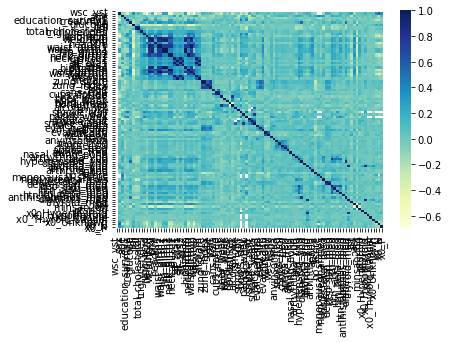

In [190]:
import seaborn as sns
# Heatmap
corr = data_df1.corr()
sns.heatmap(corr,
xticklabels=corr.columns,
yticklabels=corr.columns,
cmap= 'YlGnBu')
corr_df = corr.unstack().reset_index() # Unstack correlation matrix 
corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_df.sort_values(by='correlation',ascending=False, inplace=True) # sort by correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation
corr_df.head()

In [299]:
corr_df.to_csv(index=False, path_or_buf='/home/mnm7/code/pandit-a/dreamteam/notebooks/feature_correlation.csv')

In [188]:
corr_df[corr_df['correlation'] > 0.5].head(120)

,feature_1,feature_2,correlation
3135,zung_index,zung_score,1.000000
3039,zung_score,zung_index,1.000000
1771,hip_girth2,hipgirthm,0.999958
2443,hipgirthm,hip_girth2,0.999958
1674,hip_girth1,hipgirthm,0.999953
...,...,...,...
1952,neck_girth2,weightkg,0.752497
2534,neckgirthm,weightkg,0.752471
1190,weightkg,neckgirthm,0.752471
1855,neck_girth1,weightkg,0.752109


In [300]:
pwd

'/home/mnm7/code/pandit-a/dreamteam/notebooks'

In [302]:
X.to_csv(path_or_buf='/home/mnm7/code/pandit-a/dreamteam/notebooks/X_csv.csv')

### Train Test Splits

In [90]:
X_split, X_val, y_split, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X_split, y_split, test_size=0.3, random_state=42)

### Scaling

In [92]:
numeric_features = ['creatinine', 'glucose', 'hdl', 'ldl','total_cholesterol', 'triglycerides', 'uric_acid', 'weightkg', 'bmi',
       'headcm', 'waist_girth1', 'waist_girth2', 'hip_girth1', 'hip_girth2',
       'neck_girth1', 'neck_girth2', 'sit_sys1', 'sit_dia1', 'sit_sys2',
       'sit_dia2', 'hipgirthm', 'neckgirthm', 'waistgirthm', 'waisthip',
       'sitsysm', 'sitdiam', 'zung_score', 'zung_index', 'state',
       'trait', 'beer_week', 'wine_week', 'hard_week', 'bowls_day', 'packs_week', 'cigars_day',
       'smoke_years', 'pack_years','workday', 'weekend',
       'naps', 'snore_freq',
       'num_pregnancies', 'ahi',
       'minsao2tst', 'ptstl90', 'age', 'heightcm', 'cans_cola', 'cups_coffee',
       'caffeine', 'alcohol_wk', 'smoke', 'eval_general', 'eval_life','eval_health', 
       'snore_vol', 'choke_freq',
       'apnea_freq', 'awake_freq', 'ho_score']


In [93]:
X

,wsc_vst,sex,age,education_survey1,creatinine,glucose,hdl,ldl,total_cholesterol,triglycerides,...,minsao2tst,ptstl90,x0_Hyperthyroid,x0_Hypothyroid,x0_Nodule,x0_Thyroid Cancer,x0_Unknown,x0_C,x0_N,x0_P
wsc_id,,,,,,,,,,,,,,,,,,,,,
10119,1,0,52,6.0,0.90,89.0,52.0,149.0,228.0,137.0,...,93.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10191,1,1,50,5.0,0.80,96.0,77.0,122.0,222.0,117.0,...,94.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10198,1,1,57,4.0,0.90,103.0,48.0,146.0,211.0,85.0,...,87.2,0.7,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
10226,1,0,55,4.0,1.40,131.0,39.0,107.0,173.0,135.0,...,89.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10241,1,1,51,4.0,0.90,102.0,37.0,135.0,228.0,281.0,...,84.8,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99481,1,0,60,5.0,1.12,99.0,57.0,116.0,193.0,99.0,...,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99651,1,0,69,5.0,1.40,206.0,36.0,112.0,184.0,181.0,...,76.9,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99761,1,1,71,3.0,0.80,122.0,73.0,125.0,234.0,178.0,...,89.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [133]:
X_train

,wsc_vst,sex,age,education_survey1,creatinine,glucose,hdl,ldl,total_cholesterol,triglycerides,...,minsao2tst,ptstl90,x0_Hyperthyroid,x0_Hypothyroid,x0_Nodule,x0_Thyroid Cancer,x0_Unknown,x0_C,x0_N,x0_P
wsc_id,,,,,,,,,,,,,,,,,,,,,
68487,1,0,45,4.0,1.0,88.0,46.0,134.0,197.0,84.0,...,87.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42870,1,0,48,6.0,1.1,101.0,65.0,136.0,218.0,84.0,...,74.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19067,1,1,67,3.0,1.5,118.0,42.0,57.0,120.0,105.0,...,80.6,1.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
75801,1,0,71,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,83.7,6.9,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
15320,1,0,69,4.0,1.0,104.0,46.0,131.0,226.0,244.0,...,89.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10771,1,1,41,4.0,0.9,113.0,42.0,91.0,147.0,68.0,...,92.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
35023,1,0,66,5.0,1.1,90.0,61.0,130.0,208.0,84.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38628,1,1,44,5.0,1.0,98.0,34.0,107.0,169.0,142.0,...,92.8,0.1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [89]:
X_scaled = X.copy()
scaler = MinMaxScaler()
X_scaled[numeric_features] = scaler.fit_transform(X_scaled[numeric_features])
X_scaled

,wsc_vst,sex,age,education_survey1,creatinine,glucose,hdl,ldl,total_cholesterol,triglycerides,...,minsao2tst,ptstl90,x0_Hyperthyroid,x0_Hypothyroid,x0_Nodule,x0_Thyroid Cancer,x0_Unknown,x0_C,x0_N,x0_P
wsc_id,,,,,,,,,,,,,,,,,,,,,
10119,1,0,0.333333,6.0,0.250000,0.198661,0.412698,0.588933,0.668622,0.171679,...,0.975052,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10191,1,1,0.288889,5.0,0.222222,0.214286,0.611111,0.482213,0.651026,0.146617,...,0.979210,0.000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10198,1,1,0.444444,4.0,0.250000,0.229911,0.380952,0.577075,0.618768,0.106516,...,0.906445,0.007,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
10226,1,0,0.400000,4.0,0.388889,0.292411,0.309524,0.422925,0.507331,0.169173,...,0.933472,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10241,1,1,0.311111,4.0,0.250000,0.227679,0.293651,0.533597,0.668622,0.352130,...,0.881497,0.020,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99481,1,0,0.511111,5.0,0.311111,0.220982,0.452381,0.458498,0.565982,0.124060,...,0.000000,0.004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99651,1,0,0.711111,5.0,0.388889,0.459821,0.285714,0.442688,0.539589,0.226817,...,0.799376,0.025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99761,1,1,0.755556,3.0,0.222222,0.272321,0.579365,0.494071,0.686217,0.223058,...,0.933472,0.000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Modelling

In [77]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [78]:
cv_results = cross_validate(LinearRegression(), X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

cv_results['test_score'].mean()

-64.62936123184394

In [71]:
cv_results['test_score']

array([-111.07264946,  -46.34169134,  -71.88287591,  -46.04518381,
        -47.80440564])

## Pipelines

In [105]:
categoric = X.copy()
categoric.drop(columns = numeric_features, inplace=True)
categorical_features = categoric.columns
categoric

,wsc_vst,sex,education_survey1,nondrinker,smoke_curr,smoke_quit,anyinsomnia,nasal_cong_none,arrhythmia_ynd,any_cvd,...,diabetes_med,thyroid_med,x0_Hyperthyroid,x0_Hypothyroid,x0_Nodule,x0_Thyroid Cancer,x0_Unknown,x0_C,x0_N,x0_P
wsc_id,,,,,,,,,,,,,,,,,,,,,
10119,1,0,6.0,0.0,0.0,0.0,0,0,0,0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10191,1,1,5.0,0.0,0.0,0.0,0,1,0,0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10198,1,1,4.0,1.0,0.0,1986.0,0,0,0,0,...,0,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
10226,1,0,4.0,0.0,1.0,0.0,0,0,0,1,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10241,1,1,4.0,1.0,0.0,1974.0,0,0,1,0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99481,1,0,5.0,0.0,0.0,0.0,1,0,0,0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99651,1,0,5.0,0.0,0.0,1965.0,0,0,0,0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99761,1,1,3.0,0.0,0.0,0.0,0,0,0,0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [212]:
numeric_features

['creatinine',
 'glucose',
 'hdl',
 'ldl',
 'total_cholesterol',
 'triglycerides',
 'uric_acid',
 'weightkg',
 'bmi',
 'headcm',
 'waist_girth1',
 'waist_girth2',
 'hip_girth1',
 'hip_girth2',
 'neck_girth1',
 'neck_girth2',
 'sit_sys1',
 'sit_dia1',
 'sit_sys2',
 'sit_dia2',
 'hipgirthm',
 'neckgirthm',
 'waistgirthm',
 'waisthip',
 'sitsysm',
 'sitdiam',
 'zung_score',
 'zung_index',
 'state',
 'trait',
 'beer_week',
 'wine_week',
 'hard_week',
 'bowls_day',
 'packs_week',
 'cigars_day',
 'smoke_years',
 'pack_years',
 'workday',
 'weekend',
 'naps',
 'snore_freq',
 'num_pregnancies',
 'ahi',
 'minsao2tst',
 'ptstl90',
 'age',
 'heightcm',
 'cans_cola',
 'cups_coffee',
 'caffeine',
 'alcohol_wk',
 'smoke',
 'eval_general',
 'eval_life',
 'eval_health',
 'snore_vol',
 'choke_freq',
 'apnea_freq',
 'awake_freq',
 'ho_score']

In [106]:
categorical_features

Index(['wsc_vst', 'sex', 'education_survey1', 'nondrinker', 'smoke_curr',
       'smoke_quit', 'anyinsomnia', 'nasal_cong_none', 'arrhythmia_ynd',
       'any_cvd', 'hypertension_ynd', 'diabetes_ynd', 'asthma_ynd',
       'thyroid_ynd', 'arthritis_ynd', 'apnea', 'menopausal_status',
       'cholesterol_med', 'depression_med', 'dep_ssri_med', 'htn_med',
       'htn_acei_med', 'htn_beta_med', 'htn_diuretic_med',
       'antihistamines_med', 'diabetes_med', 'thyroid_med', 'x0_Hyperthyroid',
       'x0_Hypothyroid', 'x0_Nodule', 'x0_Thyroid Cancer', 'x0_Unknown',
       'x0_C', 'x0_N', 'x0_P'],
      dtype='object')

In [107]:
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))])
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler())
])

In [108]:
preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
], remainder='passthrough')
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', RobustScaler())]),
                                 ['creatinine', 'glucose', 'hdl', 'ldl',
                                  'total_cholesterol', 'triglycerides',
                                  'uric_acid', 'weightkg', 'bmi', 'headcm',
                                  'waist_girth1', 'waist_girth2', 'hip_girth1',
                                  'hip_girth2', 'neck_girth1', 'neck_girth2',
                                  'sit_sys1', 'sit_dia1'...
       'any_cvd', 'hypertension_ynd', 'diabetes_ynd', 'asthma_ynd',
       'thyroid_ynd', 'arthritis_ynd', 'apnea', 'menopausal_status',
       'cholesterol_med', 'depression_med', 'dep_ssri_med', 'htn_med',
       'htn_acei_med', 'htn_beta_med', 'htn_diuretic_med',
       'antihistamines_med', 'diabetes_med', 'thyroid_med', 'x0_Hyperthyroid',
       'x0_Hypothyroid', 'x0_Nodule', 'x0_Thyroid Cancer', 'x0_Unknown',
       'x0_C', 'x0_N', 'x0_P'],
      dtype='object'))])

In [118]:
final_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('ridge', Ridge())
])
final_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['creatinine', 'glucose',
                                                   'hdl', 'ldl',
                                                   'total_cholesterol',
                                                   'triglycerides', 'uric_acid',
                                                   'weightkg', 'bmi', 'headcm',
                                                   'waist_girth1',
                                                   'waist_girth2', 'hip_girth1',
                                                   'hip_girth2', 'neck_girth1',
                                                   'ne...
       'thyroid_ynd', 'arthritis_ynd', 'apnea', 'menopausal_status',
       'cholesterol_med', 'depression_med', 'dep_ssri_med', 'htn_med',
       'htn_acei_med', 'htn_beta_med', 'htn_diuretic_med',
       'antihistamines_med', 'diabetes_med', 'thyroid_med', 'x0_Hyperthyroid',
       'x0_Hypothyroid', 'x0_Nodule', 'x0_Thyroid Cancer', 'x0_Unknown',
       'x0_C', 'x0_N', 'x0_P'],
      dtype='object'))])),
                ('ridge', Ridge())])

In [119]:
ridge_pipe_model = final_pipe.fit(X_train, y_train)
y_pred = ridge_pipe_model.predict(X_test)

In [120]:
print(f'Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}')
print(f'Mean Absolute Percentage Error: {mean_absolute_percentage_error(y_test, y_pred)}')

Mean Absolute Error: 46.030704090240306
Mean Absolute Percentage Error: 0.12994328818951265


In [121]:
final_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'ridge', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__num', 'preprocessor__cat', 'preprocessor__num__memory', 'preprocessor__num__steps', 'preprocessor__num__verbose', 'preprocessor__num__imputer', 'preprocessor__num__scaler', 'preprocessor__num__imputer__add_indicator', 'preprocessor__num__imputer__copy', 'preprocessor__num__imputer__fill_value', 'preprocessor__num__imputer__missing_values', 'preprocessor__num__imputer__strategy', 'preprocessor__num__imputer__verbose', 'preprocessor__num__scaler__copy', 'preprocessor__num__scaler__quantile_range', 'preprocessor__num__scaler__unit_variance', 'preprocessor__num__scaler__with_centering', 'preprocessor__num__scaler__with_scaling', 'preprocessor__cat__memory', 'preprocessor__cat__steps', 'preprocessor__cat__verbose', 'preprocessor__cat__im

In [126]:
param_grid = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid = GridSearchCV(final_pipe, param_grid, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          RobustScaler())]),
                                                                         ['creatinine',
                                                                          'glucose',
                                                                          'hdl',
                                                                          'ldl',
                                                                          'total_cholesterol',
                                                                          'triglycerides',
                                                                          'uric_acid',
                                                                          'weightkg',
                                                                          'bmi',
                                                                          'headcm',
                                                                          'waist_girth1',
                                                                          'waist_girth2',
                                                                          'hip_girth1',
                                                                          'hip_gi...
       'cholesterol_med', 'depression_med', 'dep_ssri_med', 'htn_med',
       'htn_acei_med', 'htn_beta_med', 'htn_diuretic_med',
       'antihistamines_med', 'diabetes_med', 'thyroid_med', 'x0_Hyperthyroid',
       'x0_Hypothyroid', 'x0_Nodule', 'x0_Thyroid Cancer', 'x0_Unknown',
       'x0_C', 'x0_N', 'x0_P'],
      dtype='object'))])),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})

In [127]:
grid.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['creatinine', 'glucose',
                                                   'hdl', 'ldl',
                                                   'total_cholesterol',
                                                   'triglycerides', 'uric_acid',
                                                   'weightkg', 'bmi', 'headcm',
                                                   'waist_girth1',
                                                   'waist_girth2', 'hip_girth1',
                                                   'hip_girth2', 'neck_girth1',
                                                   'ne...
       'thyroid_ynd', 'arthritis_ynd', 'apnea', 'menopausal_status',
       'cholesterol_med', 'depression_med', 'dep_ssri_med', 'htn_med',
       'htn_acei_med', 'htn_beta_med', 'htn_diuretic_med',
       'antihistamines_med', 'diabetes_med', 'thyroid_med', 'x0_Hyperthyroid',
       'x0_Hypothyroid', 'x0_Nodule', 'x0_Thyroid Cancer', 'x0_Unknown',
       'x0_C', 'x0_N', 'x0_P'],
      dtype='object'))])),
                ('ridge', Ridge(alpha=100))])

In [128]:
y_pred_grid = grid.best_estimator_.predict(X_test)

In [267]:
y_baseline = pd.Series([np.mean(y_train)]*len(y_test))
print(f'Mean Absolute Error (Baseline Prediction):{mean_absolute_error(y_test, y_baseline)}')

Mean Absolute Error (Baseline Prediction):47.0436297095056


In [129]:
print(f'Mean Absolute Error: {mean_absolute_error(y_test, y_pred_grid)}')
print(f'Mean Absolute Percentage Error: {mean_absolute_percentage_error(y_test, y_pred_grid)}')

Mean Absolute Error: 45.19289415739793
Mean Absolute Percentage Error: 0.12786945662781712


In [134]:
X_scaled

,wsc_vst,sex,age,education_survey1,creatinine,glucose,hdl,ldl,total_cholesterol,triglycerides,...,minsao2tst,ptstl90,x0_Hyperthyroid,x0_Hypothyroid,x0_Nodule,x0_Thyroid Cancer,x0_Unknown,x0_C,x0_N,x0_P
wsc_id,,,,,,,,,,,,,,,,,,,,,
10119,1,0,0.333333,6.0,0.250000,0.198661,0.412698,0.588933,0.668622,0.171679,...,0.975052,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10191,1,1,0.288889,5.0,0.222222,0.214286,0.611111,0.482213,0.651026,0.146617,...,0.979210,0.000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10198,1,1,0.444444,4.0,0.250000,0.229911,0.380952,0.577075,0.618768,0.106516,...,0.906445,0.007,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
10226,1,0,0.400000,4.0,0.388889,0.292411,0.309524,0.422925,0.507331,0.169173,...,0.933472,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10241,1,1,0.311111,4.0,0.250000,0.227679,0.293651,0.533597,0.668622,0.352130,...,0.881497,0.020,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99481,1,0,0.511111,5.0,0.311111,0.220982,0.452381,0.458498,0.565982,0.124060,...,0.000000,0.004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99651,1,0,0.711111,5.0,0.388889,0.459821,0.285714,0.442688,0.539589,0.226817,...,0.799376,0.025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99761,1,1,0.755556,3.0,0.222222,0.272321,0.579365,0.494071,0.686217,0.223058,...,0.933472,0.000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [132]:
X_train

,wsc_vst,sex,age,education_survey1,creatinine,glucose,hdl,ldl,total_cholesterol,triglycerides,...,minsao2tst,ptstl90,x0_Hyperthyroid,x0_Hypothyroid,x0_Nodule,x0_Thyroid Cancer,x0_Unknown,x0_C,x0_N,x0_P
wsc_id,,,,,,,,,,,,,,,,,,,,,
68487,1,0,45,4.0,1.0,88.0,46.0,134.0,197.0,84.0,...,87.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42870,1,0,48,6.0,1.1,101.0,65.0,136.0,218.0,84.0,...,74.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19067,1,1,67,3.0,1.5,118.0,42.0,57.0,120.0,105.0,...,80.6,1.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
75801,1,0,71,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,83.7,6.9,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
15320,1,0,69,4.0,1.0,104.0,46.0,131.0,226.0,244.0,...,89.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10771,1,1,41,4.0,0.9,113.0,42.0,91.0,147.0,68.0,...,92.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
35023,1,0,66,5.0,1.1,90.0,61.0,130.0,208.0,84.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38628,1,1,44,5.0,1.0,98.0,34.0,107.0,169.0,142.0,...,92.8,0.1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))])
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler())
])

In [147]:
########## CUSTOM OHE-2 ##########
#'Need to use sparse=False, handle_unknown='ignore' when instantiating
from sklearn.preprocessing import OneHotEncoder
class CustomOHE1(OneHotEncoder):  
    def transform(self, *args, **kwargs):
        return pd.DataFrame(super().transform(*args, **kwargs), columns=self.get_feature_names())

In [154]:
class CustomColumnTransformer(ColumnTransformer):
    def transform(self, *args, **kwargs):
        return pd.DataFrame(super().transform(*args, **kwargs), columns=self.get_feature_names())
    def fit_transform(self, *args, **kwargs):
        return pd.DataFrame(super().fit_transform(*args, **kwargs), columns=self.get_feature_names())

In [289]:

preprocessor = CustomColumnTransformer([
    #('num_transformer', numerical_transformer, numeric_features),
    ('custom_ohe', CustomOHE1(sparse=False, handle_unknown='ignore'), categorical_features)
])
preprocessor.fit(X_train)
preprocessor.transform(X_train)
variable = preprocessor.fit_transform(X_train)
variable

,custom_ohe__x0_1,custom_ohe__x1_0,custom_ohe__x1_1,custom_ohe__x2_0.0,custom_ohe__x2_2.0,custom_ohe__x2_3.0,custom_ohe__x2_4.0,custom_ohe__x2_5.0,custom_ohe__x2_6.0,custom_ohe__x3_0.0,...,custom_ohe__x30_0.0,custom_ohe__x30_1.0,custom_ohe__x31_0.0,custom_ohe__x31_1.0,custom_ohe__x32_0.0,custom_ohe__x32_1.0,custom_ohe__x33_0.0,custom_ohe__x33_1.0,custom_ohe__x34_0.0,custom_ohe__x34_1.0
0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
703,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
704,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
705,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


In [151]:
colname_ohe = CustomColumnTransformer(ColumnTransformer)
type(colname_ohe)

__main__.CustomOHE

In [152]:
preprocessor2 = ColumnTransformer([
    ('num', numerical_transformer, numeric_features),
    ('cat', colname_ohe, categorical_features)
], remainder='passthrough')
preprocessor2

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', RobustScaler())]),
                                 ['creatinine', 'glucose', 'hdl', 'ldl',
                                  'total_cholesterol', 'triglycerides',
                                  'uric_acid', 'weightkg', 'bmi', 'headcm',
                                  'waist_girth1', 'waist_girth2', 'hip_girth1',
                                  'hip_girth2', 'neck_girth1', 'neck_girth2',
                                  'sit_sys1', 'sit_dia1'...
       'any_cvd', 'hypertension_ynd', 'diabetes_ynd', 'asthma_ynd',
       'thyroid_ynd', 'arthritis_ynd', 'apnea', 'menopausal_status',
       'cholesterol_med', 'depression_med', 'dep_ssri_med', 'htn_med',
       'htn_acei_med', 'htn_beta_med', 'htn_diuretic_med',
       'antihistamines_med', 'diabetes_med', 'thyroid_med', 'x0_Hyperthyroid',
       'x0_Hypothyroid', 'x0_Nodule', 'x0_Thyroid Cancer', 'x0_Unknown',
       'x0_C', 'x0_N', 'x0_P'],
      dtype='object'))])

In [160]:
r_scaler = RobustScaler()
ohe = OneHotEncoder()
categorical_features

Index(['wsc_vst', 'sex', 'education_survey1', 'nondrinker', 'smoke_curr',
       'smoke_quit', 'anyinsomnia', 'nasal_cong_none', 'arrhythmia_ynd',
       'any_cvd', 'hypertension_ynd', 'diabetes_ynd', 'asthma_ynd',
       'thyroid_ynd', 'arthritis_ynd', 'apnea', 'menopausal_status',
       'cholesterol_med', 'depression_med', 'dep_ssri_med', 'htn_med',
       'htn_acei_med', 'htn_beta_med', 'htn_diuretic_med',
       'antihistamines_med', 'diabetes_med', 'thyroid_med', 'x0_Hyperthyroid',
       'x0_Hypothyroid', 'x0_Nodule', 'x0_Thyroid Cancer', 'x0_Unknown',
       'x0_C', 'x0_N', 'x0_P'],
      dtype='object')

In [218]:
X

,wsc_vst,sex,age,education_survey1,creatinine,glucose,hdl,ldl,total_cholesterol,triglycerides,...,minsao2tst,ptstl90,x0_Hyperthyroid,x0_Hypothyroid,x0_Nodule,x0_Thyroid Cancer,x0_Unknown,x0_C,x0_N,x0_P
wsc_id,,,,,,,,,,,,,,,,,,,,,
10119,1,0,52,6.0,0.90,89.0,52.0,149.0,228.0,137.0,...,93.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10191,1,1,50,5.0,0.80,96.0,77.0,122.0,222.0,117.0,...,94.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10198,1,1,57,4.0,0.90,103.0,48.0,146.0,211.0,85.0,...,87.2,0.7,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
10226,1,0,55,4.0,1.40,131.0,39.0,107.0,173.0,135.0,...,89.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10241,1,1,51,4.0,0.90,102.0,37.0,135.0,228.0,281.0,...,84.8,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99481,1,0,60,5.0,1.12,99.0,57.0,116.0,193.0,99.0,...,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99651,1,0,69,5.0,1.40,206.0,36.0,112.0,184.0,181.0,...,76.9,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99761,1,1,71,3.0,0.80,122.0,73.0,125.0,234.0,178.0,...,89.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [270]:
X[numeric_features]

,creatinine,glucose,hdl,ldl,total_cholesterol,triglycerides,uric_acid,weightkg,bmi,headcm,...,alcohol_wk,smoke,eval_general,eval_life,eval_health,snore_vol,choke_freq,apnea_freq,awake_freq,ho_score
wsc_id,,,,,,,,,,,,,,,,,,,,,
10119,0.90,89.0,52.0,149.0,228.0,137.0,7.2,85.5,27.6,59.5,...,2,0,1,1,1,1,1,1,1,69
10191,0.80,96.0,77.0,122.0,222.0,117.0,3.4,73.0,25.3,54.9,...,1,0,1,2,2,1,1,1,1,48
10198,0.90,103.0,48.0,146.0,211.0,85.0,5.9,115.5,46.9,56.7,...,0,1,1,1,3,9,1,1,1,67
10226,1.40,131.0,39.0,107.0,173.0,135.0,8.5,79.2,26.5,56.8,...,42,1,1,3,3,4,2,9,1,57
10241,0.90,102.0,37.0,135.0,228.0,281.0,7.1,100.6,34.4,57.7,...,0,1,2,1,5,2,9,9,1,62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99481,1.12,99.0,57.0,116.0,193.0,99.0,4.6,84.0,25.6,58.0,...,0,0,1,1,2,2,1,1,1,50
99651,1.40,206.0,36.0,112.0,184.0,181.0,7.7,102.5,35.1,60.0,...,1,1,1,1,2,4,9,9,2,63
99761,0.80,122.0,73.0,125.0,234.0,178.0,4.7,94.0,40.7,54.5,...,3,0,1,1,2,3,9,9,9,56


In [283]:
#NUMERIC FEATURES
r_scaler = StandardScaler()
X_scaled_num = pd.DataFrame(r_scaler.fit_transform(X.copy()[numeric_features]), columns=numeric_features)
X_scaled_num

,creatinine,glucose,hdl,ldl,total_cholesterol,triglycerides,uric_acid,weightkg,bmi,headcm,...,alcohol_wk,smoke,eval_general,eval_life,eval_health,snore_vol,choke_freq,apnea_freq,awake_freq,ho_score
0,-0.270090,-0.414594,0.105396,0.870146,0.673424,-0.106606,1.020362,-0.242718,-0.567039,1.171081,...,-0.321126,-1.004462,-0.643931,-1.460443,-1.598622,-1.020897,-0.774924,-0.701261,-0.365678,0.750225
1,-0.649703,-0.203443,1.596079,0.188467,0.549488,-0.324493,-1.260089,-0.840516,-0.888873,-0.868215,...,-0.516905,-1.004462,-0.643931,-0.046583,-0.397784,-1.020897,-0.774924,-0.701261,-0.365678,-1.383465
2,-0.270090,0.007709,-0.133113,0.794404,0.322273,-0.673112,0.240208,1.191998,2.133572,-0.070229,...,-0.712684,0.995558,-0.643931,-1.460443,0.803054,1.645306,-0.774924,-0.701261,-0.365678,0.547017
3,1.627976,0.852316,-0.669758,-0.190243,-0.462652,-0.128394,1.800517,-0.544008,-0.720959,-0.025897,...,7.510032,0.995558,-0.643931,1.367277,0.803054,-0.021071,-0.474323,1.606479,-0.365678,-0.469027
4,-0.270090,-0.022456,-0.789013,0.516683,0.673424,1.462182,0.960350,0.479422,0.384472,0.373096,...,-0.712684,0.995558,0.678070,-1.460443,3.204730,-0.687622,1.629884,1.606479,-0.365678,0.038995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118,0.565059,-0.112949,0.403533,0.036983,-0.049534,-0.520591,-0.539947,-0.314454,-0.846895,0.506094,...,-0.712684,-1.004462,-0.643931,-1.460443,-0.397784,-0.687622,-0.774924,-0.701261,-0.365678,-1.180257
1119,1.627976,3.114655,-0.848640,-0.064006,-0.235437,0.372746,1.320422,0.570288,0.482421,1.392744,...,-0.516905,0.995558,-0.643931,-1.460443,-0.397784,-0.021071,1.629884,1.606479,0.107974,0.140599
1120,-0.649703,0.580835,1.357570,0.264209,0.797359,0.340063,-0.479935,0.163785,1.266018,-1.045545,...,-0.125347,-1.004462,-0.643931,-1.460443,-0.397784,-0.354346,1.629884,1.606479,3.423543,-0.570631
1121,-0.649703,-0.414594,1.059433,-0.064006,0.136370,-0.411648,-0.659970,-1.294842,-0.958837,-0.380557,...,-0.321126,-1.004462,-0.643931,-0.046583,-1.598622,1.645306,-0.774924,-0.701261,-0.365678,0.140599


In [284]:
#CATEGORICAL FEATURES
X_scaled_cat = X.copy()
XS_temp = ohe.fit_transform(X_scaled_cat[categorical_features])
cat_col_names = ohe.get_feature_names(X_scaled_cat[categorical_features].columns)
X_cat_merge = pd.DataFrame(XS_temp, columns = cat_col_names)
X_cat_merge

,wsc_vst_1,sex_0,sex_1,education_survey1_0.0,education_survey1_1.0,education_survey1_2.0,education_survey1_3.0,education_survey1_4.0,education_survey1_5.0,education_survey1_6.0,...,x0_Thyroid Cancer_0.0,x0_Thyroid Cancer_1.0,x0_Unknown_0.0,x0_Unknown_1.0,x0_C_0.0,x0_C_1.0,x0_N_0.0,x0_N_1.0,x0_P_0.0,x0_P_1.0
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1119,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1120,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1121,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


In [291]:
#CONCATENATE DFS
X_merged = pd.concat([X_scaled_num, X_cat_merge], axis=1)
X_merged

,creatinine,glucose,hdl,ldl,total_cholesterol,triglycerides,uric_acid,weightkg,bmi,headcm,...,x0_Thyroid Cancer_0.0,x0_Thyroid Cancer_1.0,x0_Unknown_0.0,x0_Unknown_1.0,x0_C_0.0,x0_C_1.0,x0_N_0.0,x0_N_1.0,x0_P_0.0,x0_P_1.0
0,-0.270090,-0.414594,0.105396,0.870146,0.673424,-0.106606,1.020362,-0.242718,-0.567039,1.171081,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,-0.649703,-0.203443,1.596079,0.188467,0.549488,-0.324493,-1.260089,-0.840516,-0.888873,-0.868215,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,-0.270090,0.007709,-0.133113,0.794404,0.322273,-0.673112,0.240208,1.191998,2.133572,-0.070229,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
3,1.627976,0.852316,-0.669758,-0.190243,-0.462652,-0.128394,1.800517,-0.544008,-0.720959,-0.025897,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,-0.270090,-0.022456,-0.789013,0.516683,0.673424,1.462182,0.960350,0.479422,0.384472,0.373096,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118,0.565059,-0.112949,0.403533,0.036983,-0.049534,-0.520591,-0.539947,-0.314454,-0.846895,0.506094,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1119,1.627976,3.114655,-0.848640,-0.064006,-0.235437,0.372746,1.320422,0.570288,0.482421,1.392744,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1120,-0.649703,0.580835,1.357570,0.264209,0.797359,0.340063,-0.479935,0.163785,1.266018,-1.045545,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1121,-0.649703,-0.414594,1.059433,-0.064006,0.136370,-0.411648,-0.659970,-1.294842,-0.958837,-0.380557,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


In [293]:
from sklearn.inspection import permutation_importance
ridge_reg = Ridge().fit(X_merged, y) # Fit model
permutation_score = permutation_importance(ridge_reg, X_merged, y, n_repeats=10) # Perform Permutation
importance_df = pd.DataFrame(np.vstack((X_merged.columns, permutation_score.importances_mean)).T) # Unstack results
importance_df.columns=['feature','score_decrease']
importance_df.sort_values(by='score_decrease', ascending = False) # Order by importance

,feature,score_decrease
23,waisthip,0.711211
22,waistgirthm,0.656073
7,weightkg,0.53322
8,bmi,0.30871
75,smoke_quit_0.0,0.184556
...,...,...
180,x0_Thyroid Cancer_1.0,-0.00004
5,triglycerides,-0.000045
168,antihistamines_med_1,-0.000082
167,antihistamines_med_0,-0.000082


In [171]:
X.columns

Index(['wsc_vst', 'sex', 'age', 'education_survey1', 'creatinine', 'glucose',
       'hdl', 'ldl', 'total_cholesterol', 'triglycerides', 'uric_acid',
       'heightcm', 'weightkg', 'bmi', 'headcm', 'waist_girth1', 'waist_girth2',
       'hip_girth1', 'hip_girth2', 'neck_girth1', 'neck_girth2', 'sit_sys1',
       'sit_dia1', 'sit_sys2', 'sit_dia2', 'hipgirthm', 'neckgirthm',
       'waistgirthm', 'waisthip', 'sitsysm', 'sitdiam', 'zung_score',
       'zung_index', 'state', 'trait', 'cans_cola', 'cups_coffee', 'caffeine',
       'beer_week', 'wine_week', 'hard_week', 'nondrinker', 'alcohol_wk',
       'smoke', 'smoke_curr', 'bowls_day', 'packs_week', 'cigars_day',
       'smoke_quit', 'smoke_years', 'pack_years', 'eval_general', 'eval_life',
       'eval_health', 'workday', 'weekend', 'naps', 'anyinsomnia',
       'snore_freq', 'snore_vol', 'choke_freq', 'apnea_freq', 'awake_freq',
       'nasal_cong_none', 'arrhythmia_ynd', 'any_cvd', 'hypertension_ynd',
       'diabetes_ynd', 'asthma_y

In [173]:
y

wsc_id
10119    368.0
10191    419.0
10198    384.0
10226    328.0
10241    350.5
         ...  
99481    380.0
99651    374.0
99761    340.5
99782    424.5
99883    450.0
Name: tst, Length: 1123, dtype: float64